# <center>Modelo de detecção de quedas usando CNN</center>

## Pré processamento dos dados

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import splitfolders

In [2]:
full_dataset = pd.read_csv('full_dataset.csv', index_col=0)
full_dataset.head()

,video_name,tag,start,end
0,Coffee_room_01-video (25).avi,fall,75,175
1,Coffee_room_02-video (56).avi,fall,250,350
2,Home_02-video (57).avi,nonfall,100,200
3,Home_02-video (59).avi,nonfall,100,200
4,Coffee_room_01-video (38).avi,fall,175,275


In [3]:
batch_size = 64
img_height = 224
img_width = 224
EPOCHS = 5
IMG_SHAPE = (img_width, img_height) + (3,)
data_dir = "dataset"
output="output"
splitfolders.ratio(data_dir, output="output", seed=123, ratio=(0.75, 0.1, 0.15))

Copying files: 188 files [00:00, 10882.87 files/s]


In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(output, "train"),
    seed=123,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(output, "val"),
    seed=123,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    os.path.join(output, "test"),
    target_size=(img_height, img_width),
    seed=123,
    shuffle=True,
    batch_size=batch_size)

Found 141 files belonging to 2 classes.
Found 18 files belonging to 2 classes.
Found 29 images belonging to 2 classes.


In [5]:
# Classes do modelo
class_names = train_ds.class_names
print(class_names)

['fall', 'nonfall']


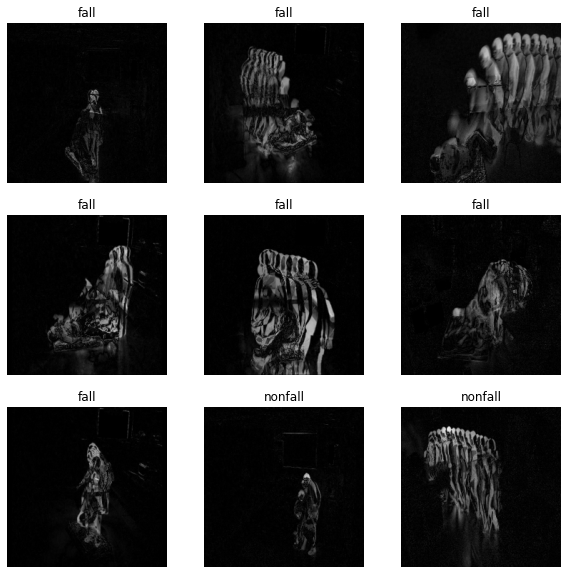

In [6]:
# Algumas imagens
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
# Tamanho do lote com as amostras e os seus rótulos
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 224, 224, 3)
(64,)


In [8]:
# AUTOTUNE para aumentar a performance durante a estapa de treinamento
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

## Etapa de Classificação

### Definição do classificador

In [10]:
# Camada de entrada do modelo
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
# Carregamento do modelo pré-treinado usando arquitetura da MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [12]:
# Definição da arquitetura com a cabeça de classificação
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
#x = preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(32,activation='relu')(x)
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [13]:
# Resumo do modelo gerado
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dropout (Dropout)            (None, 62720)             0     

### Treinamento do Modelo

In [14]:
# Definição da função callback para salvar o modelo com melhor acurácia na validação
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Treinamento do modelo com ajuste aos dados
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/5
3/3 [==============================] - 10s 2s/step - loss: 1.1908 - accuracy: 0.4326 - val_loss: 0.8731 - val_accuracy: 0.5000
Epoch 2/5
3/3 [==============================] - 7s 2s/step - loss: 0.8185 - accuracy: 0.5106 - val_loss: 0.5951 - val_accuracy: 0.5556
Epoch 3/5
3/3 [==============================] - 6s 2s/step - loss: 0.6076 - accuracy: 0.6454 - val_loss: 0.5633 - val_accuracy: 0.5556
Epoch 4/5
3/3 [==============================] - 6s 2s/step - loss: 0.6504 - accuracy: 0.6170 - val_loss: 0.5040 - val_accuracy: 0.8889
Epoch 5/5
3/3 [==============================] - 6s 2s/step - loss: 0.4688 - accuracy: 0.8511 - val_loss: 0.6476 - val_accuracy: 0.5000


## Resultado do treinamento

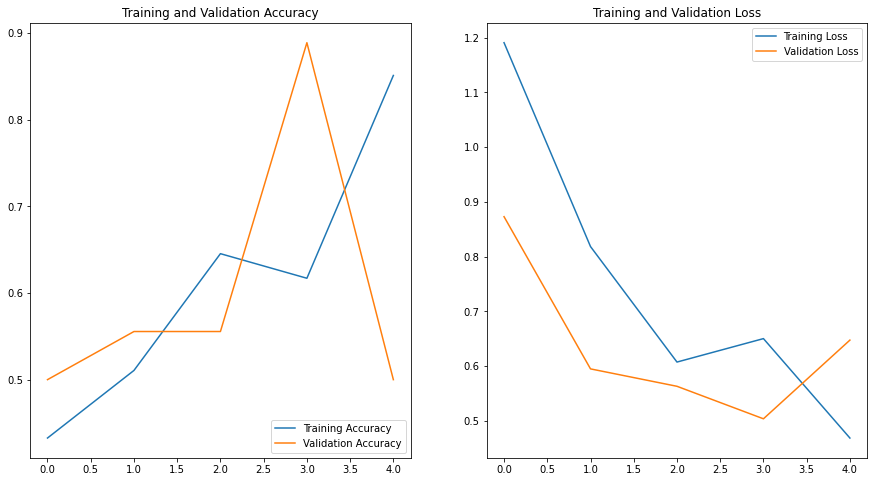

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
pred=model.predict(test_generator)
predicted_class_indices=np.argmax(pred,axis=1)

In [17]:
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [18]:
from sklearn.metrics import classification_report

y_pred = np.argmax(pred,axis=1).astype('int32')
y_true = test_generator.classes
labels = list(labels.values())
print(classification_report(y_true, y_pred, target_names=labels))

              precision    recall  f1-score   support

        fall       0.55      0.80      0.65        15
     nonfall       0.57      0.29      0.38        14

    accuracy                           0.55        29
   macro avg       0.56      0.54      0.51        29
weighted avg       0.56      0.55      0.52        29



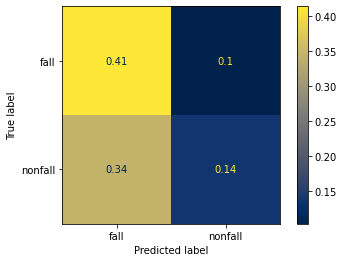

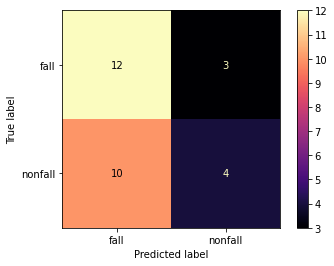

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['fall','nonfall'])
cmd.plot(cmap='cividis')

cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['fall','nonfall'])
cmd.plot(cmap='magma')

In [20]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
display(results)
#results.to_csv("results.csv",index=False)

,Filename,Predictions
0,fall/Coffee_room_01-video (13).png,fall
1,fall/Coffee_room_01-video (15).png,nonfall
2,fall/Coffee_room_01-video (2).png,fall
3,fall/Coffee_room_01-video (21).png,fall
4,fall/Coffee_room_01-video (25).png,fall
5,fall/Coffee_room_01-video (29).png,nonfall
6,fall/Coffee_room_01-video (42).png,fall
7,fall/Coffee_room_01-video (6).png,fall
8,fall/Coffee_room_01-video (7).png,fall
9,fall/Coffee_room_02-video (53).png,nonfall
